# Numerical Integration of the Second Virial Coefficient

In [1]:
import numpy as np
from scipy.integrate import trapezoid
import pandas as pd
from matplotlib import pyplot as plt

## Define the Potentials

In [2]:
class Potential:
    """
    Base class for Potential callable objects.
    """
    def __init__(self, sigma):
        """
        Potential(sigma)

        Parameters:
            sigma (angstrom): characteristic length for this potential
        """
        self.sigma = sigma
    def __call__(self, r):
        """
        Calculates the potential energy at distance r.

        Parameters:
            r (angstrom): the distance

        Returns:
            Potential energy (eV) at distance r
        """
        return 0

In [3]:
class Lennard_jones(Potential):
    """
    Lennard-Jones potential.
    """
    def __init__(self):
        """
        Lennard_jones()
        Assumes sigma of 3.4 A and epsilon of 0.01 eV.
        """
        super().__init__(3.4)
        self.epsilon = 0.01

    def __call__(self, r):
        """
        Calculates the Lennard-Jones potential at distance r.

        Parameters:
            r (angstrom): the distance
        
        Returns:
            Potential energy (eV) at distance r
        """
        V = 4*self.epsilon*((self.sigma/r)**12 - (self.sigma/r)**6)
        return V

In [4]:
class Hard_sphere(Potential):
    """
    Hard-Sphere potential.
    """
    def __init__(self):
        """
        Hard_sphere()
        Assumes sigma of 3.4 A.
        """
        super().__init__(3.4)
        self.infty = 1000

    def __call__(self, r):
        """
        Calculates the Hard-Sphere potential at distance r.

        Parameters:
            r (angstrom): the distance
        
        Returns:
            Potential energy (eV) at distance r
        """
        if r < self.sigma:
            return self.infty
        else:
            return 0

In [5]:
class Square_well(Potential):
    """
    Square-Well potential.
    """
    def __init__(self):
        """
        Square_well()
        Assumes sigma of 3.4 A, epsilon of 0.01 eV, and lambda of 1.5.
        """
        super().__init__(3.4)
        self.infty = 1000
        self.epsilon = 0.01
        self.lambda_p = 1.5

    def __call__(self, r):
        """
        Calculates the Hard-Sphere potential at distance r.

        Parameters:
            r (angstrom): the distance
        
        Returns:
            Potential energy (eV) at distance r
        """
        if r < self.sigma:
            return self.infty
        elif self.sigma<=r<self.lambda_p*self.sigma:
            return -self.epsilon
        else:
            return 0

# Numerical Integration

In [41]:
class Second_virial_coeff():
    """
    Numerically calculates the second virial coefficient
    """
    def __init__(self, potential):
        """
        Second_virial_coeff(potential)

        Parameters:
            potential: a Potential object specifying the potential energy at distance r
        """
        self.potential = potential # dependency injection

    def integrate(self, temp):
        """
        Numerically integrates B2V at temperature temp

        Parameters:
            temp (K): temperature

        Returns:
            Numeric solution for B2V at temperature temp (A^3/mol)
        """

        # define constants
        NA = 6.02e23 # mol^{-1}
        KB = 8.617333262e-5 # eV/K
        # start from a small positive value so that Lennard-Jones won't divide by 0
        r = np.linspace(1e-6, 5*self.potential.sigma, 1000)
        potentials = np.array([self.potential(r0) for r0 in r])
        integrand = (np.exp(-potentials/(KB*temp)) - 1) * (r**2)
        integral = trapezoid(integrand, x=r) # integrate using trapezoid rule
        return -2*np.pi*NA*integral # scaling factor

## Compute $B_{2V}$ for Different Temperatures

In [42]:
hard_sphere = Hard_sphere()
square_well = Square_well()
lennard_jones = Lennard_jones()

In [43]:
V2B_hard_sphere = Second_virial_coeff(hard_sphere)
V2B_square_well = Second_virial_coeff(square_well)
V2B_lennard_jones = Second_virial_coeff(lennard_jones)

In [44]:
V2B_df = pd.DataFrame({'temp': np.arange(100, 1500, 20)})

In [45]:
V2B_df['hard_sphere'] = V2B_df['temp'].apply(V2B_hard_sphere.integrate)
V2B_df['square_well'] = V2B_df['temp'].apply(V2B_square_well.integrate)
V2B_df['lennard_jones'] = V2B_df['temp'].apply(V2B_lennard_jones.integrate)
V2B_df.head()

,temp,hard_sphere,square_well,lennard_jones
0,100,4.933234e+25,-2.083349e+26,-1.609243e+26
1,120,4.933234e+25,-1.423454e+26,-1.170818e+26
2,140,4.933234e+25,-1.024412e+26,-8.878705e+25
3,160,4.933234e+25,-7.592994e+25,-6.906884e+25
4,180,4.933234e+25,-5.712761e+25,-5.457167e+25


In [46]:
V2B_df.to_csv("homework-2-2/B2V_temp.csv", index=False)

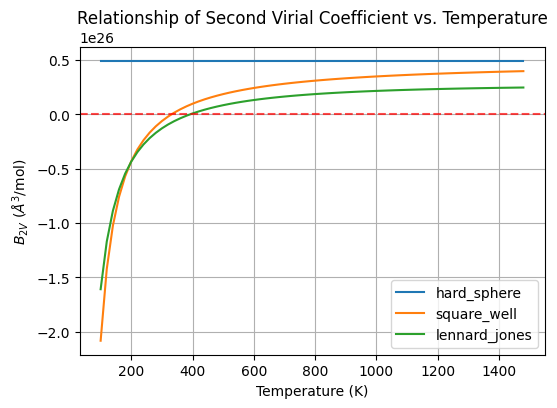

In [47]:
fig, ax = plt.subplots(figsize=(6,4))
V2B_df.plot(x='temp', ax=ax)
ax.axhline(y=0, linestyle='--', color='red', alpha=0.7)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("$B_{2V}$ ($\\AA^3$/mol)")
ax.set_title("Relationship of Second Virial Coefficient vs. Temperature")
ax.grid(True)
fig.savefig("homework-2-2/B2V_temp.png", bbox_inches='tight')

## Discussion
### comparing the behavior of $B_{2V}$ for different potentials
Under all temperatures calculated, hard sphere potential results in a $B_{2V}$ of a constant $5 \times 10^{25} Å/mol^3$. Square well and Lennard-Jones potentials both have results that appear to start from negative infinity and come closer to hard sphere potential's result as temperature increases, but Lennard-Jones appears to converge more slowly.

### Hard Sphere Potential
Hard sphere potential is either positive infinity or 0. When it's 0, the integrand turns 0 too. When it's positive infinity, the integrand approaches $(e^{-\infty}-1)r^2 = -r^2$ that is unrelated to $T$, which leads to the constant integration result at all temperatures. It is also the largest among the three, since it has no negative part.

### Square Well Potential
When $r<\sigma$, this gives the same temperature independence as hard sphere potential. However, temperature affects the integration result when $r$ is in the range $(\sigma, \lambda\sigma)$. Since this part is negative, $-u(r)/K_BT$ is positive and decreases as $T$ increases, which leads to a less postive integrand and, when multiplied by the negative factor $-2\pi$, gives a overall less negative result. Therefore it makes sense that the $B_{2V}$ curve is increasing throughout. When $T\rightarrow +\infty$, $-u(r)/K_BT\rightarrow0$, which cancels out the integrand and leads to converging result as the hard sphere potential.

### Lennard-Jones Potential
This model is a smoothed representation of the same trend represented by the square well potential model, so it makes sense that the integration results for the two follows closely. When $r<\sigma$, the potential approaches positive infinity, and it makes sense that integration across this region converges to some positive value **smaller than the limit set by the hard sphere potential**, since integration for a (appear-to-be-converging) potential curve should yield some smaller area than infinity. When $r>\sigma$, Lennard-Jones potential turns negative, and temperature would have the similar effect on the resulting $B_{2V}$ as that calculated using the square well potential. When T is small, the negative part of the potential dominates (as the exponent becomes a large positive number and exponentiation rises much more rapidly with positive exponents than it decays with negative exponents), and $B_{2V}$ approaches negative infinity. When T is large, the positive part of the potential dominates, and $B_{2V}$ approaches the limiting positive value.